In [1]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf


In [2]:
# ===============================
# Config
# ===============================
DATA_PATH = "data_HoC.csv"
SMILES_COL = "SMILES"
TARGET_COL = "VALUE"
BATCH_SIZE = 32

# ===============================
# Data
# ===============================
from chemgnn.data import load_csv, split_train_valid_test

df = load_csv(DATA_PATH)
train_df, valid_df, test_df = split_train_valid_test(df)

# ===============================
# Dataset (training)
# ===============================
from chemgnn.features.nfp_features import atom_featurizer, bond_featurizer
from chemgnn.datasets.graph_tf import build_preprocessor, make_tf_dataset

preprocessor = build_preprocessor(
    atom_featurizer,
    bond_featurizer,
    train_df[SMILES_COL]
)

train_ds = make_tf_dataset(
    preprocessor,
    train_df,
    smiles_col=SMILES_COL,
    target_col=TARGET_COL,
    batch_size=BATCH_SIZE,
    shuffle=True        # ✅ 학습용
)

valid_ds = make_tf_dataset(
    preprocessor,
    valid_df,
    smiles_col=SMILES_COL,
    target_col=TARGET_COL,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = make_tf_dataset(
    preprocessor,
    test_df,
    smiles_col=SMILES_COL,
    target_col=TARGET_COL,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# ===============================
# Train model
# ===============================
from chemgnn.train.gnn_train import train_and_evaluate_gnn

model, test_pred = train_and_evaluate_gnn(
    preprocessor,
    train_ds,
    valid_ds,
    test_ds,
    test_df[TARGET_COL].values,
    num_features=64,
    layers=6,
    lr=1e-4,
    epochs=100,
)

# ===============================
# 🔴 Prediction-only dataset (중요)
# ===============================
train_ds_pred = make_tf_dataset(
    preprocessor,
    train_df,
    smiles_col=SMILES_COL,
    target_col=TARGET_COL,
    batch_size=BATCH_SIZE,
    shuffle=False       # 🔴 핵심
)

train_pred = model.predict(train_ds_pred).squeeze()
test_pred  = model.predict(test_ds).squeeze()

# ===============================
# Evaluation
# ===============================
from chemgnn.evaluate import regression_metrics

metrics_test = regression_metrics(
    test_df[TARGET_COL].values,
    test_pred
)

print("Test metrics")
metrics_test


C:\Users\jyyeo\anaconda3\envs\myenv310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\jyyeo\anaconda3\envs\myenv310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.



15/15 [==============================] - 1s 59ms/step
Test metrics


{'MAE': 0.17210079047631208,
 'RMSE': 0.43341989608378334,
 'R2': 0.9917412059322696}

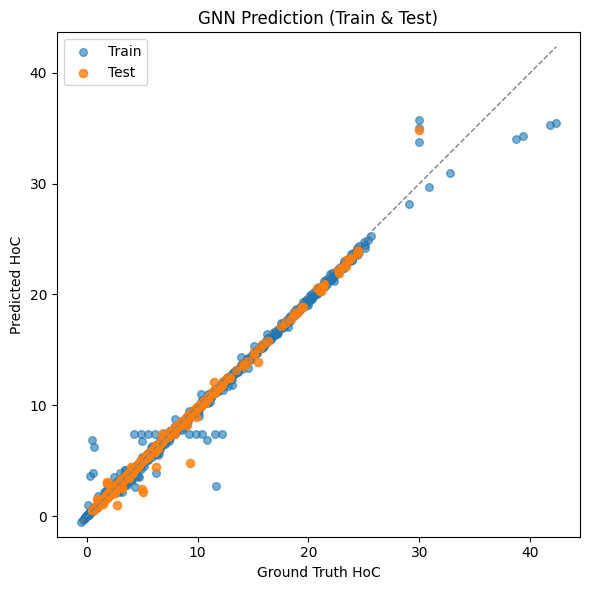

In [3]:
plt.figure(figsize=(6, 6))

# Train set
plt.scatter(
    train_df[TARGET_COL],
    train_pred,
    alpha=0.6,
    s=30,
    label="Train",
)

# Test set
plt.scatter(
    test_df[TARGET_COL],
    test_pred,
    alpha=0.8,
    s=35,
    label="Test",
)

# y = x reference line
min_val = min(
    train_df[TARGET_COL].min(),
    test_df[TARGET_COL].min(),
)
max_val = max(
    train_df[TARGET_COL].max(),
    test_df[TARGET_COL].max(),
)

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    "--",
    color="gray",
    linewidth=1,
)

plt.xlabel("Ground Truth HoC")
plt.ylabel("Predicted HoC")
plt.title("GNN Prediction (Train & Test)")
plt.legend()
plt.axis("equal")
plt.tight_layout()
plt.show()

